# Imports and Data Information

In [1]:
# Regression
from statsmodels.formula.api import logit
from auxiliary_functions import *
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Data, maths, etc.
import numpy as np
import pandas as pd
# Plotting results
import matplotlib.pyplot as plt
import seaborn as sns
import forestplot as fp
# Formatting
from rich.console import Console
from rich.markdown import Markdown
console = Console()


## Dataset

In [2]:
cmv = pd.read_csv("data/enriched_datasets/cmv_all_features.csv", sep="\t")

As explained in the paper, the experiments are done with the average prediction probabilities of the _mixed-domain storytelling_ and _masked emotion_ classifiers, which for emotion is further _aggregated_ from predictions for two halves of an instance. Due to the annotation process however, there are multiple further variants for these features. All possible feature variants are included in the dataset and are listed here to simplify future experiments. The table below gives an overview of annotation fields, including accumulated hyperclasses and modified features:

This results in the following features:

| **Variable/feature name** | **Feature**|
|---|---|
| - | text_id |
| `persuasiveness` | Data column containing the binary label of dependent variable (DV) |
| `emotion_orig` | Binary aggregated emotion labels predicted with original training data, _anger\_orig, boredom\_orig, disgust\_orig, fear\_orig, guilt\_shame\_orig, joy\_orig, pride\_orig, relief\_orig, sadness\_orig, trust\_orig_ |
| `emotion_masked` | Binary aggregated emotion labels predicted with original training data, _anger\_masked, boredom\_masked, disgust\_masked, fear\_masked, guilt\_shame\_masked, joy\_masked, pride\_masked, relief\_masked, sadness\_masked, trust\_masked_ |
| `negative_[masked/orig]` | Binary feature denoting the presence of any negative emotion aggregated from the classification results of _anger, boredom, disgust, fear, guilt/shame_ and _sadness_ of the corresponding classifier (`masked`, `orig`) |
| `positive_[masked/orig]` | Binary feature for the presence of any positive emotion aggregated from _joy, pride, relief, surprise, trust_ |
| `emotionality_[masked/orig]` | Sum of all predicted emotions for one training variant (`masked`, `orig`), the feature can adapt values [0;11] depending on how many of the eleven emotions were predicted for the instance |
| `prob_emo_[masked/orig]` | Output probabilities of the _masked/original_ classifier for emotion features |
| `emotion[_probs]_[masked/orig]_progression` | $\Delta$ of the emotion prediction of the first and second half of each instance, i.e., instead of aggregating, the two values are subtracted, -1 to 1, based on either probability output or binary label |
| `emotion[_probs]_[masked/orig]_whole` | Probability output or binary label of the emotion classifiers on the whole instance |
| `emotion[_probs]_[masked/orig]_[beginning/end]` | Probability output or binary label of the emotion classifiers on the first or second half of an instance |
| `hedging` | Absolute and relative hedge counts for the first, last and all sentences of an instance, _avg\_hedge, final\_abs\_hedge, final\_hedge, first\_abs\_hedge, first\_hedge, global\_abs\_hedge_ |
| `storytelling` | Binary storytelling labels, _storytelling\_one\_domain, storytelling\_mixed\_domain_ |
| `storytelling_probs` | Prediction probabilities from storytelling classifiers, _prob\_storytelling\_mixed\_domain, prob\_storytelling\_one\_domain_ |

In [3]:
storytelling = ['storytelling_mixed_domain', 'storytelling_one_domain']
storytelling_probs = ['prob_storytelling_mixed_domain', 'prob_storytelling_one_domain']

hedging = ['first_abs_hedge', 'first_avg_hedge', 'final_abs_hedge', 'final_avg_hedge', 'whole_abs_hedge', 'whole_avg_hedge']

In [4]:
# Binary aggregated prediction based on masked training data
emotion_masked = [
    'anger_masked_agg', 'boredom_masked_agg', 'disgust_masked_agg', 
    'fear_masked_agg', 'guilt_shame_masked_agg', 'joy_masked_agg', 
    'pride_masked_agg', 'relief_masked_agg', 'sadness_masked_agg', 
    'trust_masked_agg'
]
# Prediction probabilities based on masked training data
# This is the relevant feature variant used below
emotion_probs_masked = [
    'prob_anger_masked_agg', 'prob_boredom_masked_agg', 'prob_disgust_masked_agg', 
    'prob_fear_masked_agg', 'prob_guilt_shame_masked_agg', 'prob_joy_masked_agg', 
    'prob_pride_masked_agg', 'prob_relief_masked_agg', 'prob_sadness_masked_agg', 
    'prob_trust_masked_agg'
    ]
# Emotion difference between binary predictions for two halves of an instance based on masked training data
emotion_masked_progression = [
    'anger_masked_progress', 'boredom_masked_progress', 'disgust_masked_progress', 
    'fear_masked_progress', 'guilt_shame_masked_progress', 'joy_masked_progress', 
    'pride_masked_progress', 'relief_masked_progress', 'sadness_masked_progress', 
    'trust_masked_progress'
]
# Emotion difference between probabilities of two halves of an instance based on masked training data
emotion_probs_masked_progression = [
    'prob_anger_masked_progress', 'prob_boredom_masked_progress', 'prob_disgust_masked_progress', 
    'prob_fear_masked_progress', 'prob_guilt_shame_masked_progress', 'prob_joy_masked_progress', 
    'prob_pride_masked_progress', 'prob_relief_masked_progress', 'prob_sadness_masked_progress', 
    'prob_trust_masked_progress'
    ]
# Binary emotion prediction for the whole instance based on masked training data
emotion_masked_whole = [
    'anger_masked', 'boredom_masked', 'disgust_masked', 
    'fear_masked', 'guilt_shame_masked', 'joy_masked', 
    'pride_masked', 'relief_masked', 'sadness_masked', 
    'trust_masked'
    ]
# Emotion prediction probability for the whole instance based on masked training data
emotion_probs_masked_whole = [
    'prob_anger_masked', 'prob_boredom_masked', 'prob_disgust_masked', 
    'prob_fear_masked', 'prob_guilt_shame_masked', 'prob_joy_masked', 
    'prob_pride_masked', 'prob_relief_masked', 'prob_sadness_masked', 
    'prob_trust_masked'
    ]


# Binary aggregated prediction based on original training data
emotion_orig = [
    'anger_orig_agg', 'boredom_orig_agg', 'disgust_orig_agg', 
    'fear_orig_agg', 'guilt_shame_orig_agg', 'joy_orig_agg', 
    'pride_orig_agg', 'relief_orig_agg', 'sadness_orig_agg', 
    'trust_orig_agg'
]
# Prediction probabilities based on original training data
emotion_probs_orig = [
    'prob_anger_orig_agg', 'prob_boredom_orig_agg', 'prob_disgust_orig_agg', 
    'prob_fear_orig_agg', 'prob_guilt_shame_orig_agg', 'prob_joy_orig_agg', 
    'prob_pride_orig_agg', 'prob_relief_orig', 'prob_sadness_orig', 
    'prob_trust_orig_agg'
]
# Emotion difference between binary predictions for two halves of an instance based on original training data
emotion_orig_progression = [
    'anger_orig_progress', 'boredom_origgress', 'disgust_orig_progress', 
    'fear_origgress', 'guilt_shame_orig_progress', 'joy_origgress', 
    'pride_orig_progress', 'relief_origgress', 'sadness_orig_progress', 
    'trust_origgress'
]
# Emotion difference between probabilities of two halves of an instance based on original training data
emotion_probs_orig_progression = [
    'prob_anger_orig_progress', 'prob_boredom_orig_progress', 'prob_disgust_origgress', 
    'prob_fear_orig_progress', 'prob_guilt_shame_orig_progress', 'prob_joy_origgress', 
    'prob_pride_origgress', 'prob_relief_unm_origgress', 'prob_sadness_orig_progress', 
    'prob_trust_orig_progress'
]
# Binary emotion prediction for the whole instance based on original training data
emotion_orig_whole = [
    'anger_orig', 'boredom_orig', 'disgust_orig', 
    'fear_orig', 'guilt_shame_orig', 'joy_orig', 
    'pride_orig', 'relief_orig', 'sadness_orig', 
    'trust_orig'
]
# Emotion prediction probability for the whole instance based on original training data
emotion_probs_orig_whole = [
    'prob_anger_orig', 'prob_boredom_orig', 'prob_disgust_orig', 
    'prob_fear_orig', 'prob_guilt_shame_orig', 'prob_joy_orig', 
    'prob_pride_orig', 'prob_relief_orig', 'prob_sadness_orig', 
    'prob_trust_orig'
]

## Data distribution
Almost all features are very sparse, with _surprise_ removed from the analysis due to its complete absence from IBM ArgQ. Below are the number (#) and ratio (%) of the positive class for all binary features.

Data Distribution (binary labels)                                         

Overall number of instances: 11567                                                                                 

                               
  Feature           #       %  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  anger          6467   55.91  
  boredom         538    4.65  
  disgust        5111   44.19  
  fear            822    7.11  
  guilt/shame     631    5.46  
  joy             208    1.80  
  pride           615    5.32  
  relief          256    2.21  
  sadness         429    3.71  
  trust           159    1.37  
  storytelling   2288   19.78

<Axes: xlabel='persuasiveness', ylabel='count'>

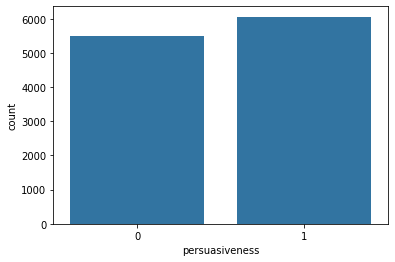

In [5]:
dist_cols = emotion_masked + ["storytelling_mixed_domain"]
l = len(cmv)
distribution = pd.DataFrame()
distribution["Feature"] = dist_cols
distribution["#"] = distribution.Feature.apply(lambda x: cmv[x].sum())
distribution["%"] = distribution["#"].apply(lambda x: 100*x/l)
distribution["Feature"] = distribution.Feature.apply(re_feats)
distribution.set_index("Feature", inplace=True)
console.print(Markdown(f"### Data Distribution (binary labels)\nOverall number of instances: {l}\n" + distribution.to_markdown(floatfmt=(".0f", ".0f",".2f"))))
sns.countplot(cmv, x="persuasiveness")

# 1 Individual Regression for Separate Features
To explore the impact of each feature separately, the following models will have just one independent variable (IV), using the variable type with the highest performance on the heldout test data from the training datasets: 
1. emotion
    - masked
2. storytelling
    - mixed domain
3. hedging
    - absolute count in first sentence
    - avg. of first sentence
    - absolute count in last sentence
    - avg. of last sentence
    - absolute count in whole instance
    - avg. of whole instance

Further, the regression models use output probabilities for _storytelling_ and _emotion_ IVs to combat data sparseness in the binary labels and enrich the models with prediction certainty information.

**NOTE:** _p_-value significance levels are assumed at 0.05 (*), 0.01 (\*\*), 0.001 (\*\*\*)

## 1.1 Emotions
The following code implements the main emotion models reported in the paper, i.e., IVs are average probability outputs by the ensembles using data with masked emotion words predicted on two halves of each Cornell CMV instance and averaged.

IV: Anger
Optimization terminated successfully.
         Current function value: 0.691954
         Iterations 3


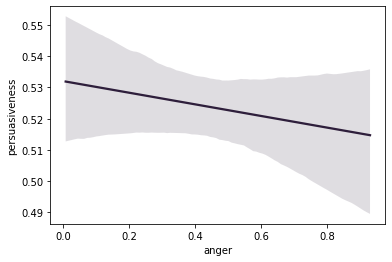

IV: Boredom
Optimization terminated successfully.
         Current function value: 0.691966
         Iterations 3


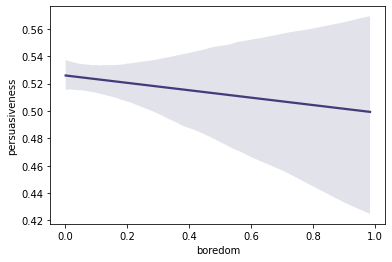

IV: Disgust
Optimization terminated successfully.
         Current function value: 0.691271
         Iterations 4


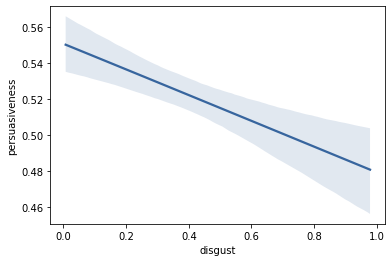

IV: Fear
Optimization terminated successfully.
         Current function value: 0.691795
         Iterations 4


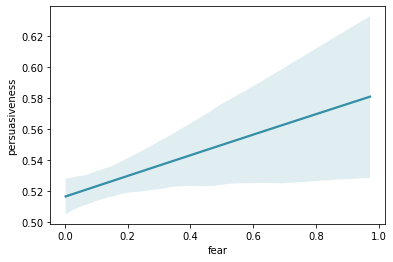

IV: Guilt/Shame
Optimization terminated successfully.
         Current function value: 0.691656
         Iterations 3


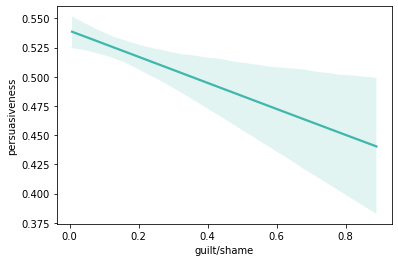

IV: Joy
Optimization terminated successfully.
         Current function value: 0.691897
         Iterations 4


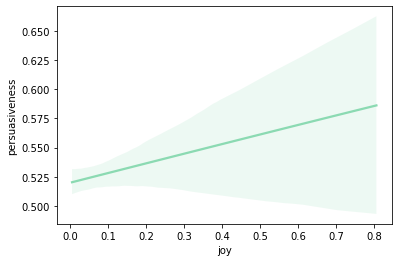

IV: Pride
Optimization terminated successfully.
         Current function value: 0.691808
         Iterations 4


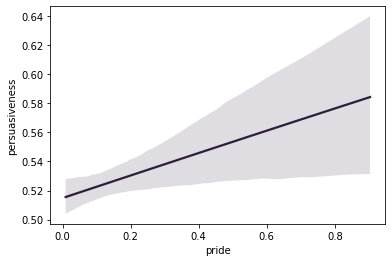

IV: Relief
Optimization terminated successfully.
         Current function value: 0.691674
         Iterations 4


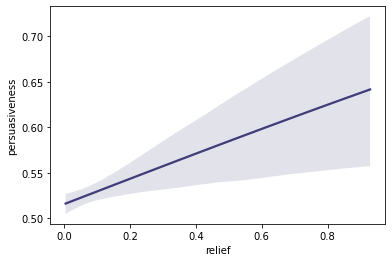

IV: Sadness
Optimization terminated successfully.
         Current function value: 0.691965
         Iterations 3


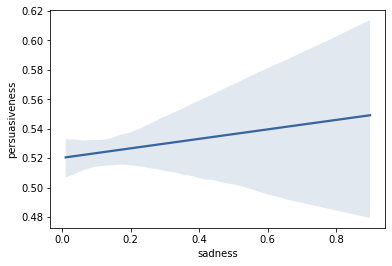

IV: Trust
Optimization terminated successfully.
         Current function value: 0.691979
         Iterations 3


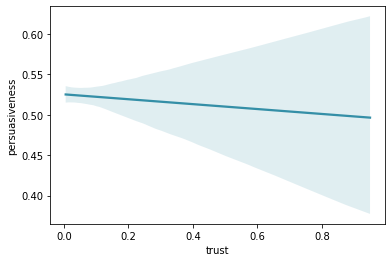

 Independent Variable     Odds   pseudo-r2   p-Value  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  anger                  0.9280      0.0000   0.37721  
  boredom                0.8974      0.0000   0.48704  
  disgust                0.7507      0.0010   0.00005  
  fear                   1.3067      0.0003   0.03510  
  guilt/shame            0.6398      0.0005   0.00563  
  joy                    1.3967      0.0001   0.14921  
  pride                  1.3651      0.0003   0.04198  
  relief                 1.7488      0.0005   0.00727  
  sadness                1.1381      0.0000   0.47002  
  trust                  0.8856      0.0000   0.65438

In [6]:
emotion_results = pd.DataFrame({
    "Independent Variable": ["/".join(emo.split("_")[1:-2]) for emo in emotion_probs_masked], 
    "Odds": [0]*len(emotion_probs_masked),
    "pseudo-r2": [0]*len(emotion_probs_masked), 
    "p-Value": [0]*len(emotion_probs_masked)
    }).set_index("Independent Variable")

for i, iv in enumerate(emotion_probs_masked):
    formula = f"persuasiveness ~ {iv}"
    emo = "/".join(iv.split("_")[1:-2])

    print("==============================================================================\nIV: ", emo.title(), sep="")
    results = logit(formula, cmv).fit()
    emotion_results.loc[emo,"pseudo-r2"] = results.prsquared
    emotion_results.loc[emo,"p-Value"] = results.pvalues[iv]
    emotion_results.loc[emo,"Odds"] = np.exp(results.params[iv])
    plot_iv(cmv, iv, "persuasiveness", "cmv", (i%6,6))

console.print(Markdown(emotion_results.to_markdown(floatfmt=(".0f", ".4f",".4f",".5f"))))

## 1.2 Storytelling


IV: Storytelling
Optimization terminated successfully.
         Current function value: 0.691731
         Iterations 4


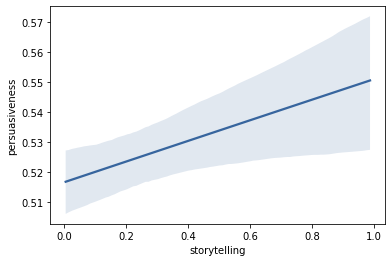

 Independent Variable     Odds   p-Value   pseudo-r2  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  storytelling           1.1483    0.0151     0.00037

In [7]:
iv = "prob_storytelling_mixed_domain"
formula = f"persuasiveness ~ {iv}"

print(f"==============================================================================\nIV: {iv.split("_")[1].title()}")
result = logit(formula, cmv).fit()
story_result = pd.DataFrame({
    "Independent Variable": "storytelling", 
    "Odds": np.exp(result.params[iv]),
    "p-Value": result.pvalues[iv],
    "pseudo-r2": result.prsquared
    }, index=["storytelling"]).set_index("Independent Variable")
plot_iv(cmv, "prob_storytelling_mixed_domain", "persuasiveness", "cmv", (2,6))
console.print(Markdown(story_result.to_markdown(floatfmt=(".0f", ".4f",".4f",".5f"))))


## 1.3 Hedging

The IVs used in the following models are the absolute count and ratio of hedge words for the first, last, and all sentences, with relative counts calculated through token ratio for sentences and sentence ratio for the whole instance:

| **Variable** | **Explanation** |
| -- | -- |
| `first_abs_hedge` | Number of hedge terms in the first sentence |
| `first_avg_hedge` | Ratio of hedge tokens in the first sentence |
| `final_abs_hedge` | Number of hedge terms in the final sentence |
| `final_avg_hedge` | Ratio of hedge tokens in the first sentence |
| `whole_abs_hedge` | Number of hedge terms in the instance |
| `whole_avg_hedge` | Ratio of hedge terms by sentence number in the instance |


IV: Hedging (First, Abs.)
Optimization terminated successfully.
         Current function value: 0.691951
         Iterations 3


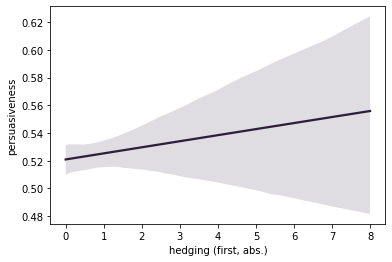


IV: Hedging (First, Avg.)
Optimization terminated successfully.
         Current function value: 0.691973
         Iterations 3


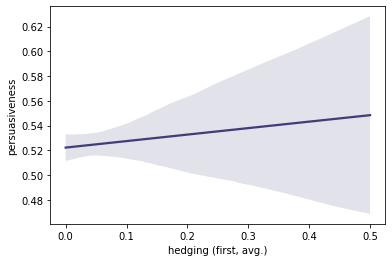


IV: Hedging (Final, Abs.)
Optimization terminated successfully.
         Current function value: 0.691987
         Iterations 3


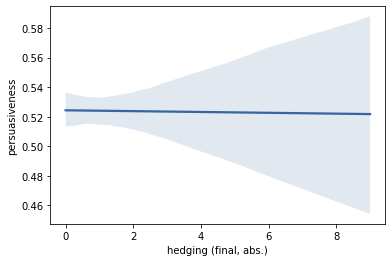


IV: Hedging (Final, Avg.)
Optimization terminated successfully.
         Current function value: 0.691907
         Iterations 3


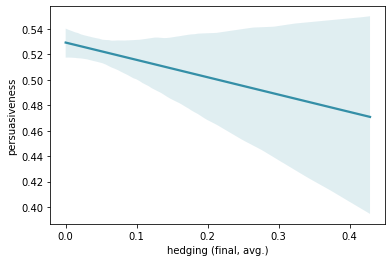


IV: Hedging (Whole, Abs.)
Optimization terminated successfully.
         Current function value: 0.684680
         Iterations 4


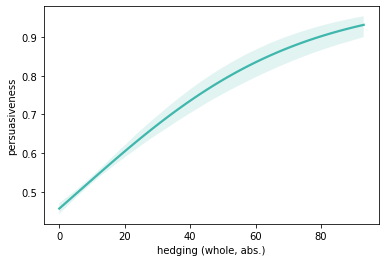


IV: Hedging (Whole, Avg.)
Optimization terminated successfully.
         Current function value: 0.691745
         Iterations 4


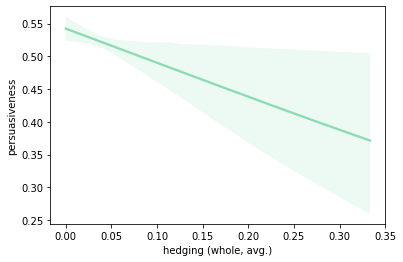

 Independent Variable      Odds   pseudo-r2   p-Value  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  hedging (first, abs.)   1.0178      0.0001   0.35848  
  hedging (first, avg.)   1.2346      0.0000   0.56513  
  hedging (final, abs.)   0.9989      0.0000   0.94665  
  hedging (final, avg.)   0.5794      0.0001   0.17351  
  hedging (whole, abs.)   1.0303      0.0106   0.00000  
  hedging (whole, avg.)   0.1242      0.0004   0.01793

In [8]:
hedge_results = pd.DataFrame(
    {
        "Independent Variable": ["hedging (first, abs.)", "hedging (first, avg.)", 
                                 "hedging (final, abs.)", "hedging (final, avg.)", 
                                 "hedging (whole, abs.)", "hedging (whole, avg.)"],
        "Odds": [0]*6,
        "pseudo-r2": [0]*6,
        "p-Value": [0]*6
    }
).set_index("Independent Variable")
for i, iv in enumerate(hedging):
    formula = f"persuasiveness ~ {iv}"
    h = iv.split("_")
    hedge = f"hedging ({h[0]}, {h[1]}.)"
    print("\n==============================================================================\nIV:", hedge.title())
    result = logit(formula, cmv).fit()
    hedge_results.loc[hedge,"pseudo-r2"] = result.prsquared
    hedge_results.loc[hedge,"Odds"] = np.exp(result.params[iv])
    hedge_results.loc[hedge,"p-Value"] = result.pvalues[iv]
    plot_iv(cmv, iv, "persuasiveness", "cmv", (i,6))

console.print(Markdown(hedge_results.to_markdown(floatfmt=(".0f", ".4f",".4f",".5f"))))

# 2 Multilinear Regression with All Features

Robust regression relies on independent variables that are not themselves correlated. Thus, for the full regression analysis without interaction, we first check for multicolinearity between all variables. To that end, we calculate the variance inflation factor between groups of two and three variables, which indicates the increased standard error of a multicolinear predictor in comparison to a non-correlated predictor (cf. Johnston et al., 2018).

In [9]:
features = ["prob_storytelling_mixed_domain", "whole_abs_hedge"] + emotion_probs_masked
h = cmv[features]
vif_data = pd.DataFrame() 
vif_data["Feature"] = h.columns 
vif_data["VIF"] = [variance_inflation_factor(h.values, i) for i in range(len(h.columns))]
vif_data["Feature"] = vif_data["Feature"].apply(re_feats)
console.print(Markdown("**Variance Inflation Factor**\n" + vif_data.to_markdown(index=False, floatfmt=".3f")))
console.print(Markdown("The highest VIF values occur in _anger_ and _disgust_, which are also the most frequent features. " \
"As the performance of _digust_ is higher than that of _anger_ on the held-out test set of the training data, " \
"we remove the latter variable from the full analysis without interaction for more robust regression results."))

features.pop(2)
h = cmv[features]
vif_data = pd.DataFrame() 
vif_data["Feature"] = h.columns 
vif_data["VIF"] = [variance_inflation_factor(h.values, i) for i in range(len(h.columns))]
vif_data["Feature"] = vif_data["Feature"].apply(re_feats)
console.print(Markdown("**Variance Inflation Factor without _anger_**\n" + vif_data.to_markdown(index=False, floatfmt=".3f")))

Variance Inflation Factor                                                                                          

                                 
  Feature                   VIF  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  storytelling            1.552  
  hedging (whole, abs.)   2.274  
  anger                   5.220  
  boredom                 1.369  
  disgust                 3.630  
  fear                    1.612  
  guilt/shame             2.512  
  joy                     2.235  
  pride                   2.664  
  relief                  1.407  
  sadness                 2.166  
  trust                   1.337

The highest VIF values occur in anger and disgust, which are also the most frequent features. As the performance of
digust is higher than that of anger on the held-out test set of the training data, we remove the latter variable   
from the full analysis without interaction for more robust regression results.

Variance Inflation Factor without anger                                                                            

                                 
  Feature                   VIF  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  storytelling            1.549  
  hedging (whole, abs.)   2.076  
  boredom                 1.305  
  disgust                 2.477  
  fear                    1.599  
  guilt/shame             2.386  
  joy                     2.138  
  pride                   2.590  
  relief                  1.397  
  sadness                 2.132  
  trust                   1.329

Optimization terminated successfully.
         Current function value: 0.691808
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691731
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691674
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684680
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691897
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691966
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691271
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691979
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691795
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691656
  

No remaining variables that were not chosen.

 Independent Variables     Odds   p-Value   pseudo-r2   Significance           
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  hedging (whole, abs.)   1.0305    0.0000      0.0106   x                      
  + relief                1.7043    0.0162      0.0112   0.0012017662073909449  
  + pride                 1.4445    0.0685      0.0117   0.005075199173121948   
  + fear                  1.2698    0.0749      0.0120   0.042542373921762834   
  + disgust               0.8946    0.1989      0.0121   0.1864970696479165     
  + guilt/shame           0.8359    0.3140      0.0121   0.3508734504176587     
  + boredom               0.8849    0.4815      0.0122   0.40959173736958554    
  + storytelling          0.9737    0.6567      0.0122   0.6728841966370651     
  + sadness               1.0600    0.7564      0.0122   0.7577825605560785     
  + joy                   1.0696    0.8159      0.0122   0.8165933464782187     
  + trust                 1.0281    0.9225      0.0122   0.9224665077649715

Full Model Results The table lists all independent variables of the full model without interaction after the       
stepwise selection process. Thus, variables are ordered from first to last selected, with the Coefficient and      
p-Value refering to the respective values of the individual IV in the full final model, while the Significance and 
pseudo-r2 refer to the model containing all IVs up to the current one. Significance is calculated via ANOVA        
comparing to the next smaller model, and thus not calculated for the first selected IV.

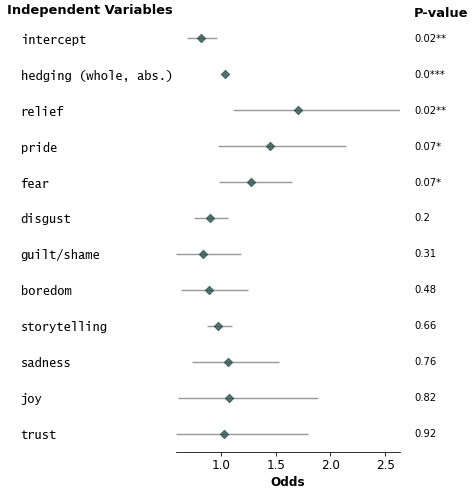

In [10]:
features = ["persuasiveness", "prob_storytelling_mixed_domain", "whole_abs_hedge"] + emotion_probs_masked[1:]

data = cmv[features]
# Using forward selection function to calculate best features
full_multi_result = forward_selection(data, "persuasiveness", "logit")
full_multi_model = full_multi_result["model"]
full_multi_remaining = full_multi_result["remaining"]
full_multi_sign = full_multi_result["significance"]
full_multi_r2 = full_multi_result["r2"]
full_multi_coef = full_multi_result["params"]

if not len(full_multi_remaining):
    console.print("No remaining variables that were not chosen.")
else:
    console.print(Markdown(f"{len(full_multi_remaining)} remaining variables that were not chosen:\n{', '.join(map(re_feats, full_multi_remaining))}"))

names = list(map(re_feats,full_multi_model.params.index[1:]))
r_list = pd.DataFrame({
    "Independent Variables": ["+ "+names[i] if i else names[i] for i in range(len(names))],
    "Odds": np.exp(full_multi_coef["coef"]),
    "p-Value": full_multi_coef["p-Value"],
    "pseudo-r2": full_multi_r2,
    "Significance": full_multi_sign
    }).set_index("Independent Variables")

console.print(Markdown(r_list.to_markdown(floatfmt=(".0f", ".4f",".4f",".4f",".5f"))))
console.print(Markdown("**Full Model Results**\nThe table lists all independent variables of the full model without interaction after the stepwise selection process. " \
"Thus, variables are ordered from first to last selected, with the Coefficient and p-Value refering to the respective values of the individual IV in the full final model, " \
"while the Significance and pseudo-r2 refer to the model containing all IVs up to the current one. Significance is calculated via ANOVA comparing to the next smaller model, "
"and thus not calculated for the first selected IV."))

params = full_multi_model.params
conf = full_multi_model.conf_int()
conf['Odds'] = full_multi_model.params
conf.columns = ['5%', '95%', 'Effect']
conf = np.exp(conf)
conf["Variables"] = ["intercept"] + [re_feats(x) for x in list(params.index)[1:]]
conf["p-Value"] = full_multi_model.pvalues

fp.forestplot(conf,  # the dataframe with results data
              estimate="Effect",  # Estimated effect size 
              ll="5%", hl="95%",  # Confidence interval limits
              varlabel="Variables",  # Variable label
              ylabel="Independent Variables",
              xlabel="Odds",
              pval="p-Value",
              ci_report=False,  # Turn off conf. int. reporting
              # Additional kwargs for customizations
              **{"marker": "D",  # Set maker symbol as diamond
                 "markersize": 35,  # Adjust marker size
                 "xlinestyle": (1, (10, 5)),  # Long dash for x-reference line 
                 "xlinecolor": "#808080",  # Gray color for x-reference line
                 "xtick_size": 12,  # Adjust x-ticker fontsize
                #  'fontfamily': 'serif'  # revert to sans-serif
                } 
              )

plt.savefig("img/cmv_multilinear_forestplot.svg", bbox_inches="tight", format="svg")

# Full Model with 2-way Interaction

Optimization terminated successfully.
         Current function value: 0.691972
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689241
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691367
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691945
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691154
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691965
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691822
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690182
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691689
  

 Independent Variables                      Odds   p-Value   pseudo-r2   Significance           
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  hedging (whole, abs.)                    1.0354    0.0000      0.0106   x                      
  + disgust : guilt/shame                  0.3700    0.0017      0.0113   0.0004153458153133491  
  + fear : pride                          53.2693    0.0096      0.0119   0.003655681906057692   
  + anger : relief                         7.3509    0.0005      0.0123   0.008617538022786005   
  + anger : hedging (whole, abs.)          0.9762    0.0027      0.0128   0.005527681849877597   
  + disgust : pride                        5.5710    0.0032      0.0132   0.008329870824424754   
  + guilt/shame : hedging (whole, abs.)    1.0487    0.0171      0.0136   0.016006989902872096

Full Model Results The table lists all independent variables of the full model with 2-way interaction after the    
stepwise selection process. Thus, variables are ordered from first to last selected, with the Coefficient and      
p-Value refering to the respective values of the individual IV in the full final model, while the Significance and 
pseudo-r2 refer to the model containing all IVs up to the current one. Significance is calculated via ANOVA        
comparing to the next smaller model, and thus not calculated for the first selected IV.

11 remaining variables and 126 interactions that were not chosen.

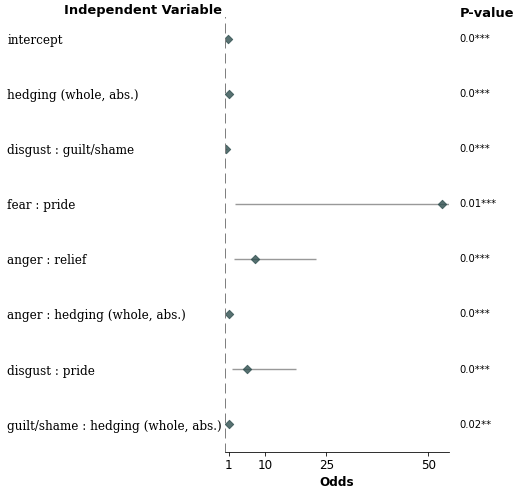

In [11]:
features = ["persuasiveness", "prob_storytelling_mixed_domain", "whole_abs_hedge"] + emotion_probs_masked

data = cmv[features]

# Using forward selection function to calculate best features based on AIC 
# and stop selection based on missing significance of model improvement (F-test)
full_result = poly_forward_selection(data, 'persuasiveness', "logit")
full_model = full_result["model"]
full_remaining = full_result["remaining"]
full_sign = full_result["significance"]
full_r2 = full_result["r2"]
full_coef = full_result["params"]["coef"]
full_p = full_result["params"]["p-Value"]

names = list(map(re_feats,full_model.params.index[1:]))
r_list = pd.DataFrame({
    "Independent Variables": ["+ "+names[i] if i else names[i] for i in range(len(names))],
    "Odds": np.exp(full_coef),
    "p-Value": full_p,
    "pseudo-r2": full_r2,
    "Significance": full_sign
}).set_index("Independent Variables")

console.print(Markdown(r_list.to_markdown(floatfmt=(".0f", ".4f",".4f",".4f",".5f"))))
console.print(Markdown("**Full Model Results**\nThe table lists all independent variables of the full model with 2-way interaction after the stepwise selection process. " \
"Thus, variables are ordered from first to last selected, with the Coefficient and p-Value refering to the respective values of the individual IV in the full final model, " \
"while the Significance and pseudo-r2 refer to the model containing all IVs up to the current one. Significance is calculated via ANOVA comparing to the next smaller model, "
"and thus not calculated for the first selected IV."))

full_params = full_model.params
full_conf = full_model.conf_int()
full_conf['Odds'] = full_model.params
full_conf.columns = ['5%', '95%', 'Effect']
full_conf = np.exp(full_conf)
# Artificially shorten large confidence intervals for better figure readability
full_conf["95%"] = full_conf["95%"].apply(lambda x: [55,x][int(x<55)])
full_conf["Variables"] = ["intercept"] + [re_feats(x) for x in list(full_params.index)[1:]]
full_conf["p-Value"] = full_model.pvalues

fp.forestplot(full_conf,
              estimate="Effect",
              ll="5%", hl="95%",
              varlabel="Variables",
              ylabel="Independent Variable",
              xlabel="Odds",
              pval="p-Value",
              ci_report=False,  # Turn off conf. int. reporting
              xticks=[1,10,25,50],  # x-ticks to be printed
              # Additional kwargs for customizations
              **{"marker": "D",  # set maker symbol as diamond
                 "markersize": 35,  # adjust marker size
                 "xlinestyle": (1, (10, 5)),  # long dash for x-reference line 
                 "xlinecolor": "#808080",  # gray color for x-reference line
                 "xtick_size": 12,  # adjust x-ticker fontsize
                 'fontfamily': 'serif'  # revert to sans-serif
                } 
              )
plt.savefig("img/cmv_poly_forestplot.svg", bbox_inches="tight", format="svg")

if not len(full_remaining):
    console.print("No remaining variables that were not chosen.")
else:
    inter = len([x for x in full_remaining if ":" in x])
    console.print(Markdown(f"{len(full_remaining)-inter} remaining variables and {inter} interactions that were not chosen."))

# References

- Ron Johnston, Kelvyn Jones, and David Manley. 2018. [Confounding and collinearity in regression analysis: a cautionary tale and an alternative procedure, illustrated by studies of British voting behaviour](https://link.springer.com/article/10.1007/s11135-017-0584-6). _Qual Quant_ 52 (1957-1976).